## Stastistical analysis

- Get mean, median, inter quartal range of each image data.
- Do box plot on each

In [4]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon


In [5]:
%matplotlib inline

DAMAGED_IMAGE_PATH = '../divided/sliced/damaged/'
OK_IMAGE_PATH = '../divided/sliced/no_damage/'
UNCATEGORIZED_PATH = '../divided/sliced/unsure/'
BASE_OK_DATA = '../divided/sliced2/'

In [6]:
sample = '../divided/sliced/damaged/slice_0_0.png'

### About the data

Two main images were obtained from PhilRice. Both of which are taken using UAV.

The images were taken from PhilRice's experimental fields.
- `08-30-2018.png` before the storm (Super Typhoon Ompong)
- `09-17-2018.png` after the storm

Each image is split into 100 equal parts for sampling.

In [7]:
def load_bw_data(directory, limit=None, include_files=None):
    counter = 0
    data = []
    f_name = []
    for _fname in os.listdir(directory):
        if include_files is not None and _fname not in include_files:
            continue
        if _fname.endswith('.png'): 
            # Read gray scale image for now
            data.append(cv2.imread(os.path.join(directory, _fname), 0))
            f_name.append(_fname)
        counter += 1
        if limit is not None:
            if counter == limit:
                break
    return data, f_name
    

def show_box_plots(data, title):
    marker = dict(markerfacecolor='g', marker='D')
    fig1, ax1 = plt.subplots(figsize=(15, 10))
    ax1.set_title(title, fontsize=10)
    ax1.boxplot(data, vert=False, flierprops=marker)
    plt.show()


def show_mixed_box_plots(data, title, labels):
    colors = ['darkseagreen', 'mistyrose']
    ok_marker = dict(marker='D')
    fig1, ax1 = plt.subplots(figsize=(50, 20))
    ax1.set_title(title, fontsize=30)
    ax1.set_axisbelow(True)
    ax1.set_xlabel('Input data')
    ax1.set_ylabel('Pixel Value')
    bp = ax1.boxplot(data, vert=True, flierprops=ok_marker)
    ax1.set_xticklabels(np.repeat(labels, 2),
                    rotation=90, fontsize=10)
    len_data = len(data)
    medians = np.empty(len_data)
    for i in range(len_data):
        box = bp['boxes'][i]
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        box_coords = np.column_stack([boxX, boxY])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=colors[i % 2]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        medianX = []
        medianY = []
        for j in range(2):
            medianX.append(med.get_xdata()[j])
            medianY.append(med.get_ydata()[j])
            ax1.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='*', markeredgecolor='k')

    
    fig1.text(0.1, 0.9, 'Not damaged',
         backgroundcolor=colors[0], color='black', weight='roman',
         size='x-large')
    fig1.text(0.1, 0.875, 'Damaged',
         backgroundcolor=colors[1],
         color='black', weight='roman', size='x-large')
    plt.show()


### Get box plot of damaged images

In [8]:
gray_data, file_names = load_bw_data(DAMAGED_IMAGE_PATH)

In [9]:
damaged_flattened_data = [_img.ravel() for _img in gray_data]

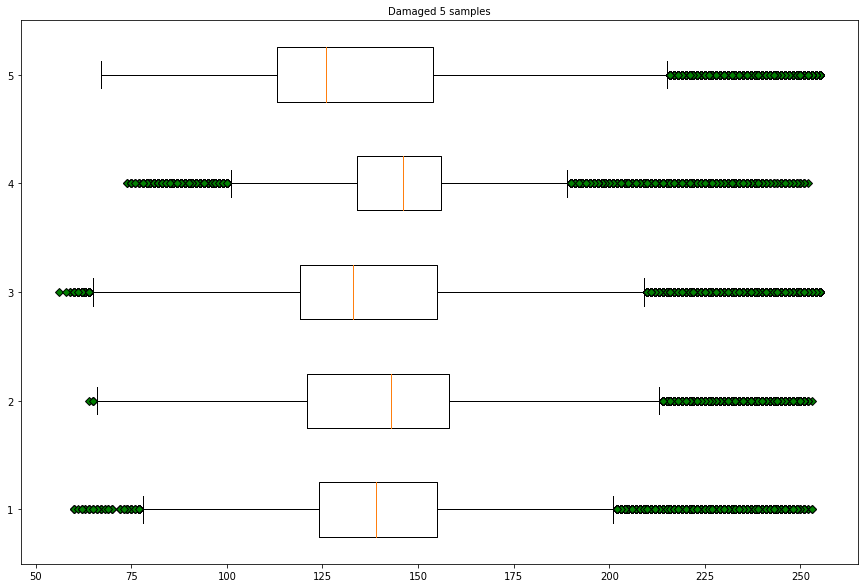

In [10]:
show_box_plots(damaged_flattened_data[:5], 'Damaged 5 samples')

### Get box plot of counterpart "before" undamaged images

In [11]:
gray_data, _ = load_bw_data(BASE_OK_DATA, include_files=file_names)

In [12]:
ok_flattened_data = [_img.ravel() for _img in gray_data]

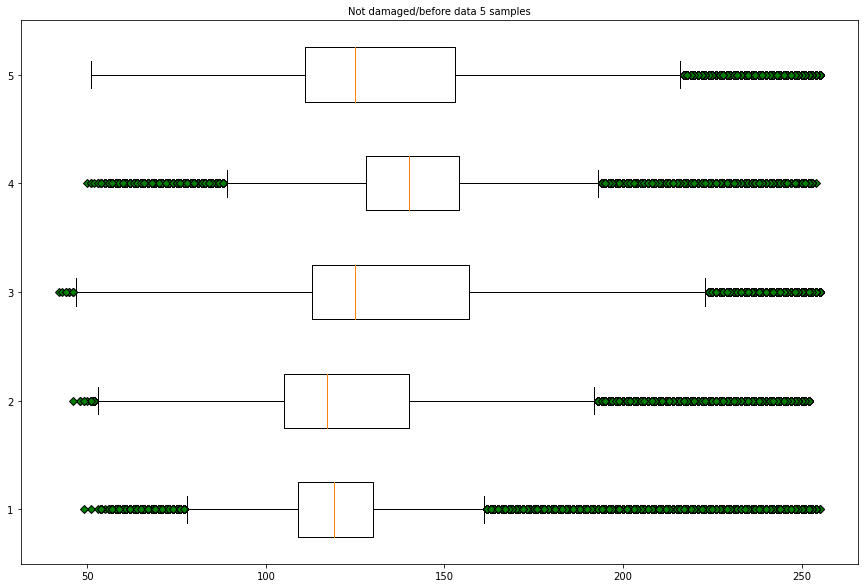

In [13]:
show_box_plots(ok_flattened_data[:5], 'Not damaged/before data 5 samples')

#### Initial observation

From the 100 sliced images, I selected 35 that I know for sure are damaged. Then I selected the same section from the "before/undamaged" set of images.

The general trend shows that images with "damage" tend to lean towards `lighter pixels` compared to the "undamaged" counterparts. This makes sense since wind damage often bends and exposes the stem part of the rice plant.


In [14]:
combined = []
for i in range(len(ok_flattened_data)):
    combined.append(ok_flattened_data[i])
    combined.append(damaged_flattened_data[i])


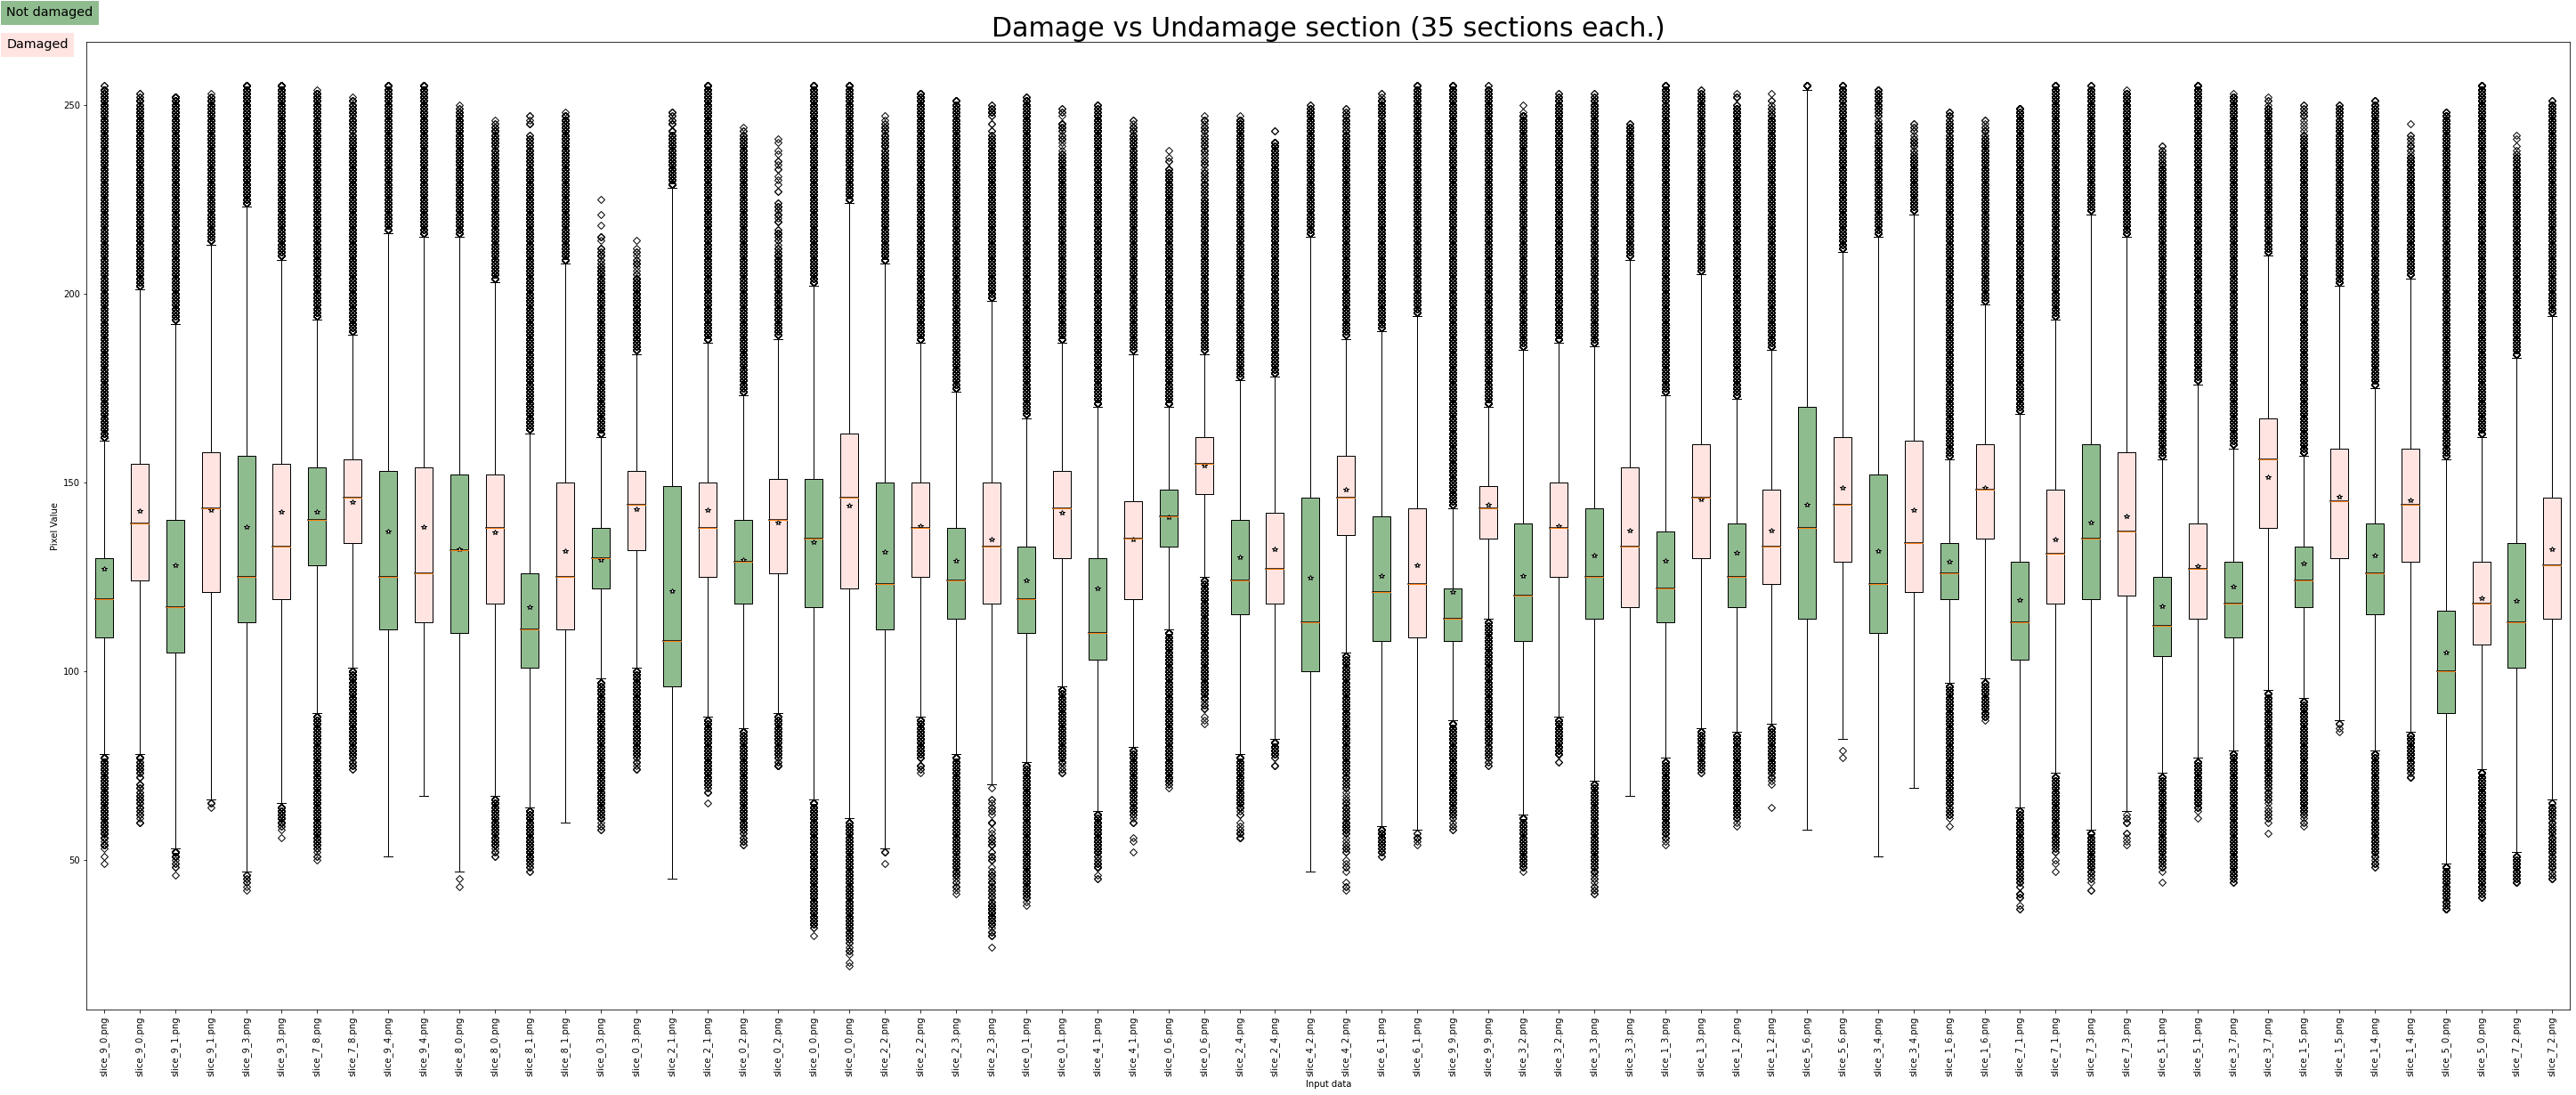

In [15]:
show_mixed_box_plots(combined, 'Damage vs Undamage section (35 sections each.)', file_names)

In [16]:
# Examine these three
sample_index = ['slice_2_1.png', 'slice_0_3.png', 'slice_0_0.png']

In [17]:
def colored_hist(img, ax):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        ax.plot(histr,color = col)
        ax.set_xlim(0,256)

def single_inspect(fname):

    ok_img = cv2.imread(os.path.join(BASE_OK_DATA, fname))
    ok_img_g = cv2.cvtColor(ok_img, cv2.COLOR_BGR2GRAY)
    ng_img = cv2.imread(os.path.join(DAMAGED_IMAGE_PATH, fname))
    ng_img_g = cv2.cvtColor(ng_img, cv2.COLOR_BGR2GRAY)

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20, 8), sharey=False)
    fig.suptitle(f'Detailed info: {fname}', fontsize=20)
    ax1.imshow(ok_img)
    ax1.set_title('Normal Image')
    ax1.set_ylabel("OK")
    colored_hist(ok_img, ax2)
    ax2.set_title('RGB Hist')
    ax3.imshow(ok_img_g, cmap=cm.gray, vmin=0, vmax=255)
    ax3.set_title('BW')
    ax4.hist(ok_img_g.ravel(),256,[0,256])
    ax4.set_title('Histogram')

    ax5.imshow(ng_img)
    ax5.set_ylabel("DAMAGED")
    colored_hist(ng_img, ax6)
    ax7.imshow(ng_img_g, cmap=cm.gray, vmin=0, vmax=255)
    ax8.hist(ng_img_g.ravel(),256,[0,256])
    plt.show()

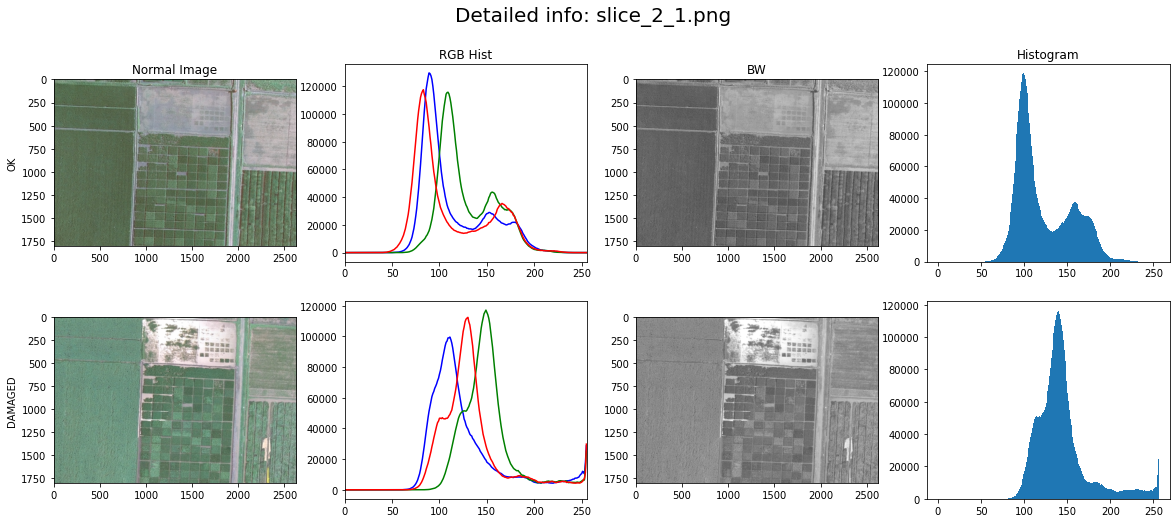

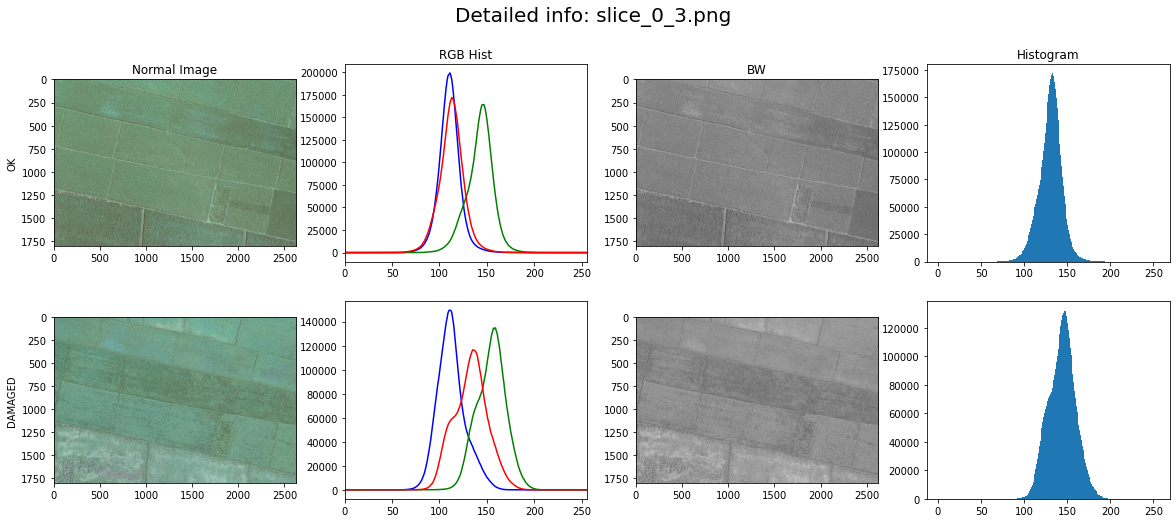

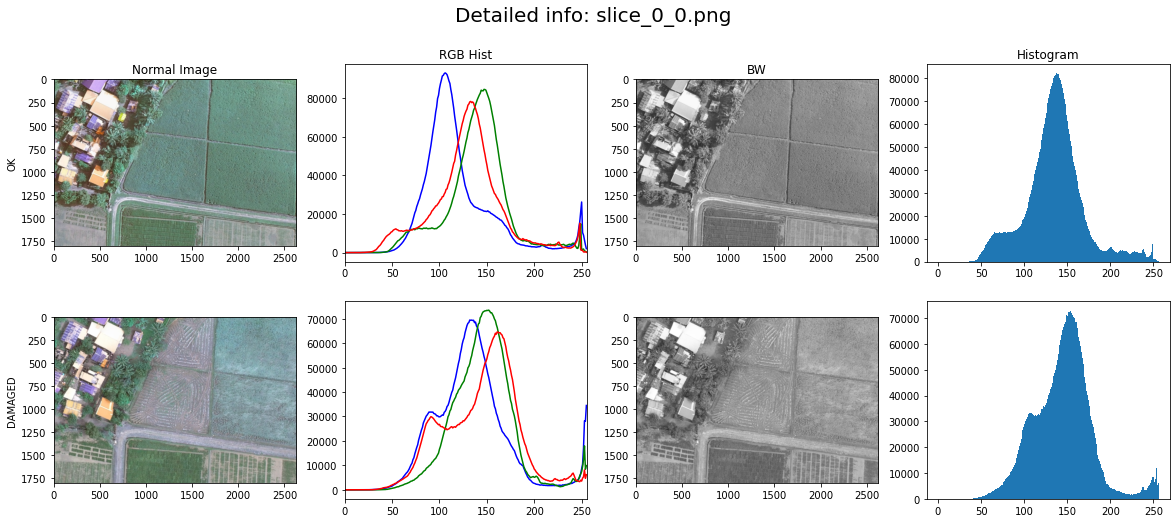

In [18]:
for _fname in sample_index:
    single_inspect(_fname)

### Damaged vs Assumed no damage

Came from same after storm image

In [19]:
# Examine these three
assumed_no_damage = ['slice_4_6.png', 'slice_2_6.png', 'slice_2_5.png']
with_damage = ['slice_2_1.png', 'slice_0_3.png', 'slice_0_0.png']

In [31]:
def colored_hist(img, ax):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        ax.plot(histr,color = col)
        ax.set_xlim(0,256)

def dual_inspect(assumed_ok, damaged):
    ok_img = cv2.imread(os.path.join(OK_IMAGE_PATH, assumed_ok))
    ok_img_g = cv2.cvtColor(ok_img, cv2.COLOR_BGR2GRAY)
    ng_img = cv2.imread(os.path.join(DAMAGED_IMAGE_PATH, damaged))
    ng_img_g = cv2.cvtColor(ng_img, cv2.COLOR_BGR2GRAY)

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20, 8), sharey=False)
    fig.suptitle(f'Detailed info: {assumed_ok} vs {damaged}', fontsize=20)
    ax1.imshow(ok_img)
    ax1.set_title('Normal Image')
    ax1.set_ylabel("OK")
    colored_hist(ok_img, ax2)
    ax2.set_title('RGB Hist')
    ax3.imshow(ok_img_g, cmap=cm.gray, vmin=0, vmax=255)
    ax3.set_title('BW')
    ax4.hist(ok_img_g.ravel(),256,[0,256])
    ax4.set_title('Histogram')

    ax5.imshow(ng_img)
    ax5.set_ylabel("DAMAGED")
    colored_hist(ng_img, ax6)
    ax7.imshow(ng_img_g, cmap=cm.gray, vmin=0, vmax=255)
    ax8.hist(ng_img_g.ravel(),256,[0,256])
    plt.show()

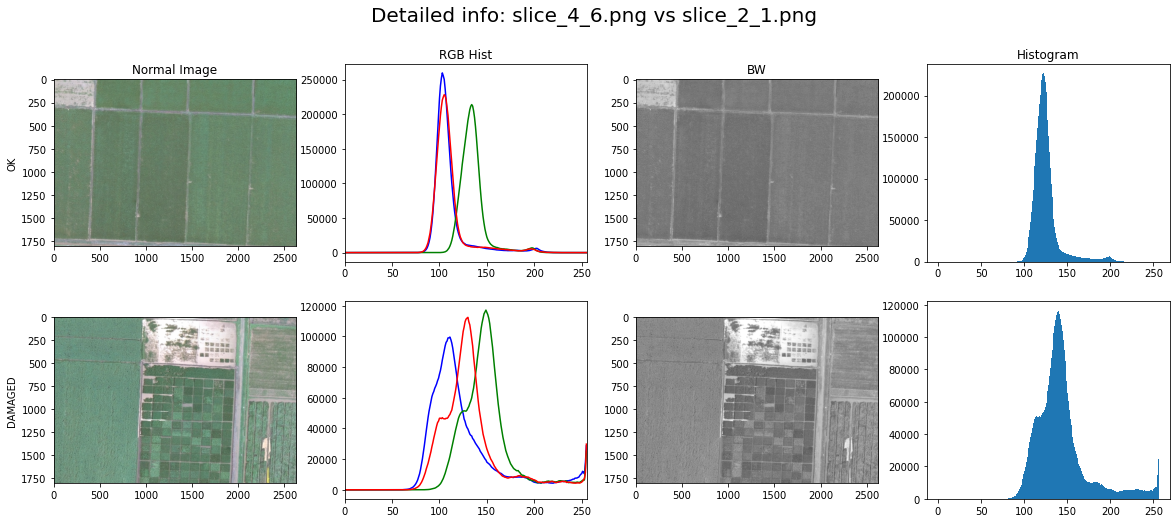

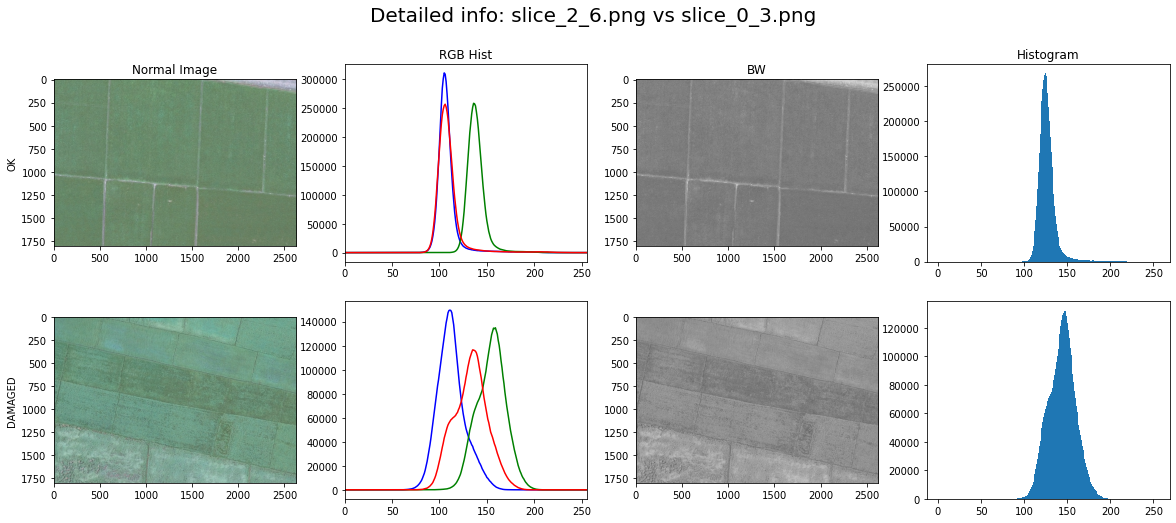

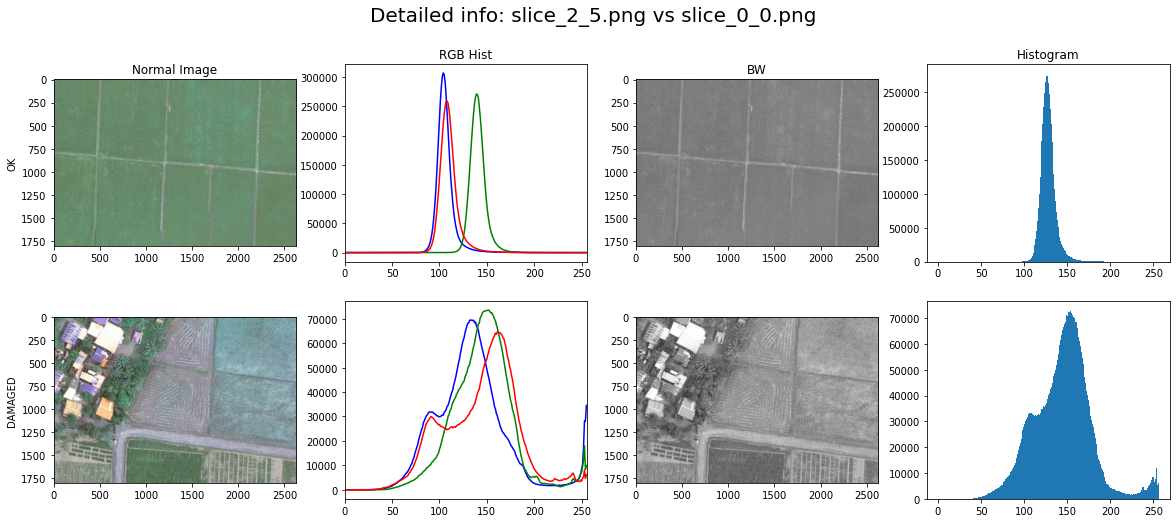

In [32]:
for i in range(len(assumed_no_damage)):
    dual_inspect(assumed_no_damage[i], with_damage[i])

### Observations

##### No damage (pre-storm) vs Damage (post-storm)

Used same viewpoints of image segment from before storm and after storm image

- There is an observed difference from the historgram of gray images.
- Mean of pixels tend to lean on lighter values for damaged images while it tends to lean on darker values for undamaged images

##### Assumed no damage (post-storm) vs Sure Damage (post-storm)

To eliminate possible issues with lighting and exact pixel intensity, some `Assumed no damage` images where sampled from the pool of post-storm image segments.

- Although extreme cases where there other objects (houses, trees) are present, it seems that the same pattern emerges
- Darker pixels are associated with no damage while lighter pixes are associated with damage images.